# Geometrical Optics - Tracing Rays and Calculating Amplitude

In [1]:
import finite_diff as fd
import torch
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
import matplotlib as mpl
from scipy.integrate import solve_ivp, cumulative_trapezoid
from scipy.special import airy
from scipy.interpolate import LinearNDInterpolator

In [2]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

# Exact and GO solution away from cutoff

#### Find first peak

In [3]:
x0  = -8
phi0 = 1

### Traditional GO Solution using only 1D from ray tracing

In [4]:
from trace_ray import trace_ray, get_t
from torch_helper import to_torch, to_torch_3D, torch_func, inner_product, angle

In [5]:
@torch_func
def n_e(r: ('vector')):
    x, y, z = r
    # return 1 + x
    return torch.exp(-x**2-y**2 + 1)*5

@torch_func
def D(r: ('vector'), k: ('vector'), omega: ('scalar')):
    x, y, z = r
    return 1 - n_e(r) - inner_product(k, k)

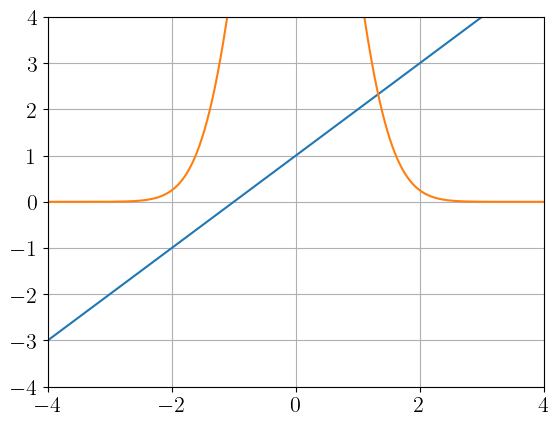

In [6]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, 1+x)
plt.plot(x, n_e(np.array([x, np.zeros_like(x), np.zeros_like(x)]), 1))
plt.grid()
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

In [7]:
r0 = np.array([x0, 0, 0])
k0 = np.array([np.sqrt(1-np.exp(-(x0**2))), 0, 0])
k0 = np.array([np.sqrt(-x0), 0, 0])
omega0 = 1.0
sol = trace_ray(r0, k0, omega0, tmin=0, tmax=8, D=D, r_min=np.array([x0, -4, -4]))
r = sol.y[:3]
k = sol.y[3:]
t = sol.t

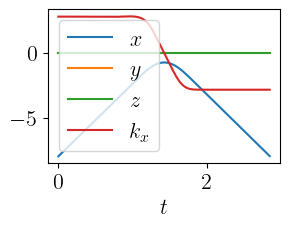

In [8]:
plt.figure(figsize=(3,2))
plt.plot(t, r.T, label=[r'$x$', r'$y$', r'$z$'])
plt.plot(t, k[0], label=r'$k_x$')
plt.xlabel(r'$t$')
plt.legend()
plt.show()

In [9]:
# def diff(f, x):
#     '''Returns three-point estimate (central difference) of derivative of f with respect to x'''
#     df = np.diff(f)
#     h = np.diff(x[:2])[0]
#     dfdx_l = (-3*f[0] + 4*f[1] - f[2])/(2*h)
#     dfdx_c = (df[1:] + df[:-1])/(2*h)
#     dfdx_r = (f[-3] - 4*f[-2] + 3*f[-1])/(2*h)
#     return np.hstack([dfdx_l, dfdx_c, dfdx_r])

In [10]:
def np_inner_product(a, b):
    if len(a.shape) == 2:
        return np.matmul(a.T, b).diagonal()
    else:
        return np.dot(a, b)

In [11]:
J = fd.grad(r[0], t)
phi = phi0*np.sqrt(J[0]/J[J>0])

gradt_r = np.vstack([fd.grad(r[0], t), fd.grad(r[1], t), fd.grad(r[2], t)])
theta0 = 0
theta = theta0 + cumulative_trapezoid(np_inner_product(k, gradt_r), t, initial=0)[J>0]

E_GO = phi*np.cos(theta)

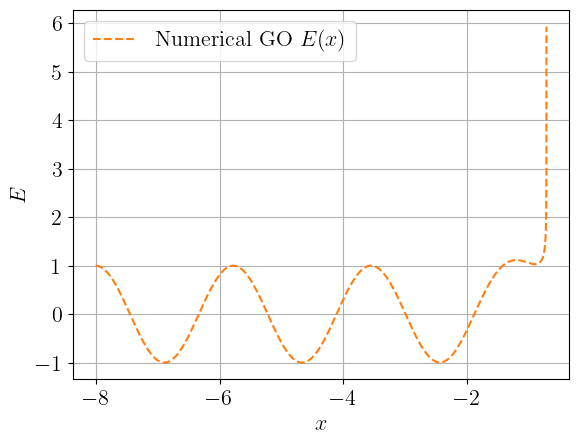

In [12]:
plt.plot(r[0][J>0], E_GO, '--', color='tab:orange', label='Numerical GO $E(x)$')
# plt.ylim(-1, 1)
plt.xlabel('$x$')
plt.ylabel('$E$')
plt.grid()
plt.legend()
plt.show()

### GO Solution using 3D Manifold

In 3D we should launch a family of rays satisfying some 2D boundary conditions.

**Note:** Consistent with Lopez 2020, in the following I'll let 3D vectors have dimension 3 has their last dimensions. The first 3 dimensions are reserved for the parametrisation: $(\tau_1, \tau_2, \tau_3) = (t, y_0, z_0)$.

**This is incosistent with the previous convention in my torch helper library, where 3D vectors had 3 as their first dimension. Eventually, I think I should standardize this by choosing 1 convention everywhere. Probably Lopez' convention is preferable.**

Importantly, it has consequences for how to calculate inner products (i.e. should we sum over first or last axis?).

In [13]:
def np_inner_product(a, b):
    return np.einsum('...i,...i->...', a, b)

In [14]:
from skimage.segmentation import flood

def get_masks_of_const_sgn(a):
    '''returns list of arrays with masks of 1.0 and 0.0s.
    The masks subdivide the values of the array, `a`,
    into regions where the sign is constant.'''
    seed = (0, 0, 0)
    regions_remaining = True
    masks = []
    while regions_remaining:
        masks.append(flood(np.signbit(a), seed))
        remaining_cells = np.argwhere(np.any(masks, axis=0) == False)
        if len(remaining_cells) > 0:
            seed = tuple(remaining_cells[0])
        else:
            regions_remaining = False
    return masks


In [15]:
n2, n3 = 100, 3

y = np.linspace(-5, 5, n2)
z = np.linspace(-5, 5, n3)

In [16]:
nt = 100
rs = np.zeros((nt, n2, n3, 3))
ks = np.zeros((nt, n2, n3, 3))
omega0 = 1.0
# ray tracing stops when it hits boundary, so we don't know
# exact number of timesteps before ray tracing has completed.
min_nt = nt
for i, y0 in enumerate(y):
    for j, z0 in enumerate(z):
        tau_ind = (i, j)
        sol = trace_ray(r0 = np.array([x0, y0, z0]), k0=np.array([np.sqrt(-x0), 0, 0]), omega0=omega0, tmin=0, tmax=10, D=D, r_min=np.array([x0, 3*np.min(y), 3*np.min(z)]), r_max=np.array([-x0, 3*np.max(y), 3*np.max(z)]), tsteps=nt)
        sol_nt = len(sol.t)
        rs[:sol_nt, i, j, :] = sol.y[:3].T
        ks[:sol_nt, i, j, :] = sol.y[3:].T
        min_nt = np.min((sol_nt, min_nt))

# Clip all rays to the same number of time steps
nt = min_nt
t = sol.t[:min_nt]
rs = rs[:min_nt, :, :, :]
ks = ks[:min_nt, :, :, :]

In [17]:
%matplotlib qt

In [18]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i, y0 in enumerate(y):
    ax.plot(rs[:, i, 0, 0], rs[:, i, 0, 1], ks[:, i, 0, 0], 'k-')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$k_x$')
for i in range(0, len(t), int(len(t)/10)):
    ax.plot(rs[i, :, 0, 0], rs[i, :, 0, 1], ks[i, :, 0, 0], '-', color='grey')
ax.view_init(20, -60, 0)
plt.tight_layout()
plt.savefig('./plots/GO_circle_dispersion_manifold.png')
plt.savefig('./plots/GO_circle_dispersion_manifold.pdf')
# fig.add_axes([0,0,1,1]).axis("off")
plt.show()

In [19]:
%matplotlib inline

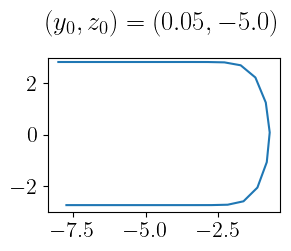

In [20]:
i, j = (int(n2/2), 0)
plt.figure(figsize=(3,2))
plt.plot(rs[:, i, j, 0], ks[:, i, j, 0])
plt.ylim(-3,3)
plt.title(r'$(y_0, z_0) = (' + str(round(y[i], 2)) + ', ' + str(round(y[j], 2)) + ')$')
plt.show()

In [21]:
J = np.linalg.det(fd.grad(rs, t, y, z))
phi = phi0*np.emath.sqrt(J[0, ...]/J)
gradt_r = fd.grad(rs, t)
theta0 = 0
theta = theta0 + cumulative_trapezoid(np_inner_product(ks, gradt_r), t, initial=0, axis=0)

In [22]:
branch_masks = get_masks_of_const_sgn(J)

In [23]:
xi = np.linspace(np.min(rs[..., 0]), np.max(rs[..., 0])+0.1, 200)
yi = np.linspace(np.min(rs[..., 1]), np.max(rs[..., 1]), 200)
zi = np.linspace(np.min(rs[..., 2]), np.max(rs[..., 2]), 200)

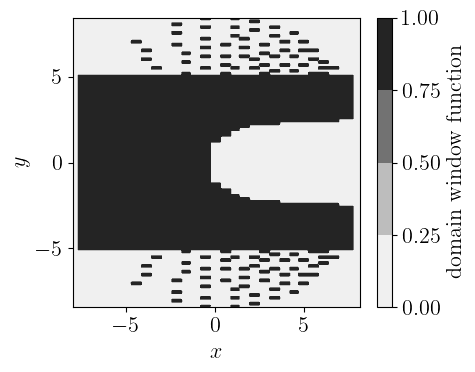

In [24]:
from scipy.interpolate import RegularGridInterpolator

H, edges = np.histogramdd(rs.reshape(-1,3), bins=(nt, n2, n3))
centers = [edge[:-1] + np.diff(edge)/2 for edge in edges]
in_region = RegularGridInterpolator(tuple(centers), (H > 0).astype(int), method='nearest', fill_value=0, bounds_error=False)

plt.figure(figsize=(5,4))
X, Y = np.meshgrid(xi, yi)
plt.contourf(X, Y, in_region((X, Y, np.zeros_like(X))), levels=3, cmap='Greys')
plt.colorbar(label='domain window function')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.tight_layout()
plt.show()

In [46]:
branch_masks = get_masks_of_const_sgn(J)
branches = [LinearNDInterpolator(rs[mask], np.real(phi[mask]*np.exp(1j*theta[mask])), fill_value=0) for mask in branch_masks if np.sum(mask)>12]
# branches = [LinearNDInterpolator(rs[mask], phi[mask]*np.cos(theta[mask]), fill_value=0) for mask in branch_masks if np.sum(mask)>12]

def interp_field_r(r):
    return in_region(r)*sum(f(r) for f in branches)

def interp_field(x, y, z):
    r = np.stack([x, y, z], axis=-1)
    return interp_field_r(r)

In [47]:
E_GO = interp_field(xi, np.zeros_like(xi), np.zeros_like(xi))

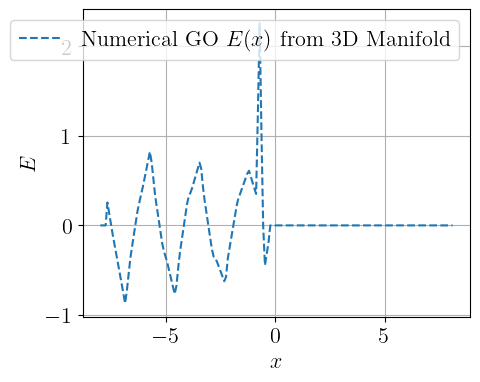

In [48]:
plt.figure(figsize=(5,4))
plt.plot(xi, E_GO, '--', color='tab:blue', label='Numerical GO $E(x)$ from 3D Manifold')
# plt.ylim(-1, 1)
plt.xlabel('$x$')
plt.ylabel('$E$')
plt.grid()
plt.legend()
plt.show()

In [49]:
X, Y = np.meshgrid(xi, yi, indexing='ij')
E_XY = interp_field(X, Y, np.zeros_like(X))

In [50]:
# plt.figure(figsize=(6,4))
# # plt.contourf(X, Y, np.real(E_XY), cmap='RdBu_r', levels=80)
# # plt.contourf(X, Y, np.imag(E_XY), cmap='RdBu_r', levels=80)
# plt.contourf(X, Y, np.real(E_XY) + np.imag(E_XY), cmap='RdBu_r', levels=80)
# # plt.contourf(X, Y, np.abs(np.real(E_XY) + np.imag(E_XY)), cmap='RdBu_r', levels=80)
# # plt.contourf(X, Y, np.abs(E_XY), cmap='RdBu_r', levels=80)
# plt.clim(-2, 2)
# plt.colorbar(label='$\mathrm{Re} \, E + \mathrm{Im} \, E $ [arb. u.]')
# plt.xlabel(r'$x$')
# plt.ylabel(r'$y$')
# plt.savefig('./plots/GO_circle_E_field_real_plus_imag.png')
# plt.savefig('./plots/GO_circle_E_field_real_plus_imag.pdf')
# plt.show()

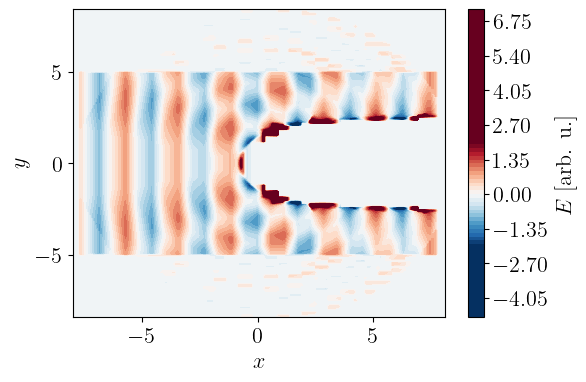

In [51]:
plt.figure(figsize=(6,4))
# plt.contourf(X, Y, np.real(E_XY), cmap='RdBu_r', levels=80)
# plt.contourf(X, Y, np.imag(E_XY), cmap='RdBu_r', levels=80)
plt.contourf(X, Y, E_XY, cmap='RdBu_r', levels=80)
# plt.contourf(X, Y, np.abs(np.real(E_XY) + np.imag(E_XY)), cmap='RdBu_r', levels=80)
# plt.contourf(X, Y, np.abs(E_XY), cmap='RdBu_r', levels=80)
plt.clim(-2, 2)
plt.colorbar(label='$E$ [arb. u.]')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.savefig('./plots/GO_circle_E_field.png')
plt.savefig('./plots/GO_circle_E_field.pdf')
plt.show()

In [52]:
# nrows, ncols = 1, 2
# fig = plt.figure(figsize=(10,4))
# # plt.contourf(X, Y, np.real(E_XY), cmap='RdBu_r', levels=80)
# # plt.contourf(X, Y, np.imag(E_XY), cmap='RdBu_r', levels=80)
# ax = fig.add_subplot(nrows, ncols, 1)
# c1 = ax.contourf(X, Y, np.real(E_XY), vmin=-2, vmax=2, cmap='RdBu_r', levels=80)
# plt.colorbar(c1, label='$\mathrm{Re} \,E$ [arb. u.]')
# plt.xlabel(r'$x$')
# plt.ylabel(r'$y$')

# ax = fig.add_subplot(nrows, ncols, 2)
# c2 = ax.contourf(X, Y, np.imag(E_XY), vmin=-2, vmax=2, cmap='RdBu_r', levels=80)
# plt.colorbar(c2, label='$\mathrm{Im} \,E$ [arb. u.]')
# # plt.contourf(X, Y, np.abs(np.real(E_XY) + np.imag(E_XY)), cmap='RdBu_r', levels=80)
# # plt.contourf(X, Y, np.abs(E_XY), cmap='RdBu_r', levels=80)
# # plt.clim(-2, 2)
# plt.xlabel(r'$x$')
# plt.ylabel(r'$y$')
# plt.savefig('./plots/GO_circle_E_field_real_and_imag.png', dpi=300)
# plt.savefig('./plots/GO_circle_E_field_real_and_imag.pdf')
# plt.tight_layout()
# plt.show()

: 

In [31]:
# fig = plt.figure(figsize=(5, 4))
# branch_masks = get_masks_of_const_sgn(J)
# for i in range(len(branch_masks)):
#     ax = fig.add_subplot(1, len(branch_masks), i+1)
#     ax.imshow(branch_masks[i][..., 0])
#     ax.set_xticks([])
#     ax.set_yticks([])
# # plt.tight_layout()